# Genetic Algorithm


In [130]:
%matplotlib inline

import logging

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from tqdm.auto import tqdm
from functools import wraps
from typing import List, Dict, Tuple, Optional

logger = logging.getLogger('francium')

logging.basicConfig(
    format="%(asctime)s, %(name)s %(levelname)s %(message)s",
    level=logging.DEBUG
)

sns.set()

2020-12-03 08:17:30,960, matplotlib.pyplot DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [131]:
class State:
    def __init__(self, init_state: Dict[str, float]):
        self.state_ : Dict[str, float] = init_state

    def __repr__(self):
        return str(self.state_)

    def __str__(self):
        return str(self.state_)

    def __getitem__(self, key) -> Dict[str, float]:
        return self.state_[key]

    def __setitem__(self, key, newval):
        self.state_[key] = newval

In [132]:
class MemoryIterator:
    def __init__(self, memory):
        self.memory_ = memory
        self.index_ = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.index_ < len(self.memory_.memory):
            result = self.memory_.memory[self.index_]
            self.index_ += 1
            return result
        raise StopIteration

In [133]:
class Memory:
    def __init__(self, retain_mem: bool = True):
        self.retain_mem = retain_mem
        self.memory: List[State] = []
        self.best_episode = None

    def __iter__(self):
        return MemoryIterator(self)

    def get_episode(self, episode: int) -> State:
        # return the state from `episode`
        return self.memory[episode]

    def add_episode(self, state: State) -> None:
        self.memory.append(state)

        if self.best_episode is None or state['z'] < self.best_episode['z']:
            self.best_episode = state

    def get_curr_state(self) -> State:
        # return from the latest state
        return self.memory[-1]

In [162]:
class Environment:
    def __init__(self, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], goal_val: Optional[State] = None, tolerance: Optional[float] = 1e-4):
        self.goal_val: State = goal_val
        self.tolerance: float = tolerance
        self.x_bounds: Tuple[float, float] = x_bounds
        self.y_bounds: Tuple[float, float] = y_bounds
    
    def get_random_init_position(self) -> State:
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds

        init_state: State = State({
            'x': np.random.uniform(low = x_min, high = x_max),
            'y': np.random.uniform(low = y_min, high = y_max),
        })

        z, _ = self.evaluate_state(init_state)

        init_state['z'] = z
        
        return init_state

    def plot_environment(self):
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds

        fig = plt.figure(figsize=(25, 10))

        # plot the 3d sphere function

        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)

        X, Y = np.meshgrid(x, y)

        Z = self.evaluation_func(X, Y)

        z_min, z_max = np.min(Z), np.max(Z)

        ax1.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap="viridis", edgecolor='none', alpha=0.7)
        cset = ax1.contour(X, Y, Z, zdir='z', offset = z_min, cmap=cm.coolwarm)
        cset = ax1.contour(X, Y, Z, zdir='x', offset = x_min, cmap=cm.coolwarm)
        cset = ax1.contour(X, Y, Z, zdir='y', offset = y_max, cmap=cm.coolwarm)
        ax1.view_init(60, 35)

        ax1.set_xlabel('X')
        ax1.set_xlim(x_min, x_max)

        ax1.set_ylabel('Y')
        ax1.set_ylim(y_min, y_max)

        ax1.set_zlabel('Z')
        ax1.set_zlim(z_min, z_max)

        # plot the contours
        ax2 = fig.add_subplot(1, 2, 2)

        cp = ax2.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
        fig.colorbar(cp) # Add a colorbar to a plot

        fig.suptitle("Environment", fontsize=20)

        plt.tight_layout()

        plt.subplots_adjust(top=0.95)

        plt.show()

    def fitness_func(self, state: State) -> float:
        eval_val = self.evaluation_func(state['x'], state['y'])
        return eval_val

    def evaluation_func(self, X, Y):
        # return np.sin(np.sqrt(X ** 2 + Y ** 2) * 2)
        return 5 * np.sin(X**2 + Y**2) + (X**2 + Y**2)

    def evaluate_state(self, state: State) -> Tuple[float, bool]:
        eval_val = self.evaluation_func(state['x'], state['y'])

        if self.goal_val:
            is_done = True if np.abs(eval_val - goal_val['z']) < self.tolerance else False
        else:
            is_done = False
        
        return eval_val, is_done

In [143]:
class Agent:
    """The AI Agent"""
    def __init__(self):
        self.population = []
        self.initialized = False

    def init_agent(self, pop_size: int, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float]):
        x_min, x_max = x_bounds
        y_min, y_max = y_bounds

        population = []
        for _ in range(pop_size):
            individual = State({
                "x": np.random.uniform(x_min, x_max),
                "y": np.random.uniform(y_min, y_max),
            })

            population.append(individual)

        self.population = population

        self.initialized = True

    def sort_population_by_fitness(self, fitness_func):
        return sorted(self.population, key=fitness_func)

    def choice_by_roulette(self, sorted_population, fitness_sum, fitness_func):
        offset = 0
        normalized_fitness_sum = fitness_sum

        lowest_fitness = fitness_func(sorted_population[0])
        if lowest_fitness < 0:
            offset = -lowest_fitness
            normalized_fitness_sum += offset * len(sorted_population)

        draw = np.random.uniform(0, 1)

        accumulated = 0
        for individual in sorted_population:
            fitness = fitness_func(individual) + offset
            probability = fitness / normalized_fitness_sum
            accumulated += probability

            if draw <= accumulated:
                return individual

    def crossover(self, individual_a, individual_b):
        xa = individual_a["x"]
        ya = individual_a["y"]

        xb = individual_b["x"]
        yb = individual_b["y"]

        return {"x": (xa + xb) / 2, "y": (ya + yb) / 2}


    def mutate(self, individual, x_bounds, y_bounds):
        x_min, x_max = x_bounds
        y_min, y_max = y_bounds

        next_x = individual["x"] + np.random.uniform(-0.05, 0.05)
        next_y = individual["y"] + np.random.uniform(-0.05, 0.05)

        # Guarantee we keep inside boundaries
        next_x = min(max(next_x, x_min), x_max)
        next_y = min(max(next_y, y_min), y_max)

        return State({"x": next_x, "y": next_y})

    def act(self, env: Environment):

        if not self.initialized:
            logger.error("=> initialize the agent: `agent.init_agent(pop_size, x_bounds, y_bounds)`")
            raise Exception("Agent not Initialized")

        next_generation = []
        sorted_by_fitness_population = self.sort_population_by_fitness(env.fitness_func)
        population_size = len(self.population)
        fitness_sum = sum(env.fitness_func(individual) for individual in self.population)

        for i in range(population_size):
            first_choice = self.choice_by_roulette(sorted_by_fitness_population, fitness_sum, env.fitness_func)
            second_choice = self.choice_by_roulette(sorted_by_fitness_population, fitness_sum, env.fitness_func)

            individual = self.crossover(first_choice, second_choice)
            individual = self.mutate(individual, env.x_bounds, env.y_bounds)
            next_generation.append(individual)
        
        self.population = next_generation

        best_individual = self.sort_population_by_fitness(env.fitness_func)[-1]

        # best indivudal is the new state
        new_state = State({
            'x': best_individual['x'],
            'y': best_individual['y']
        })


        return new_state

    def __call__(self, *args, **kwargs) -> State:
        return self.act(*args, **kwargs)

In [144]:
class Solver:
    def __init__(self, agent: Agent, environment: Environment, pop_size: int = 100):
        self.agent: Agent = agent
        self.env: Environment = environment
        self.memory: Memory = Memory(retain_mem = True)
        self.initialized: bool = False
        self.pop_size = pop_size

    def init_solver(self):
        self.agent.init_agent(
            self.pop_size,
            self.env.x_bounds,
            self.env.y_bounds
        )

        logger.info(f"=> Initialized Agent !")

        self.initialized = True

    def plot_history(self):

        # plot the sphere_function and the search_space
        x_min, x_max = self.env.x_bounds
        y_min, y_max = self.env.y_bounds

        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)

        X, Y = np.meshgrid(x, y)

        Z = self.env.evaluation_func(X, Y)

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
        
        cp = ax1.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
        fig.colorbar(cp) # Add a colorbar to a plot
    
        x_states = [mem['x'] for mem in iter(self.memory)]
        y_states = [mem['y'] for mem in iter(self.memory)]

        ax1.plot(x_states, y_states, color='black', marker='.', alpha=0.5, linewidth=1, markersize=1)
        ax1.plot(x_states[0], y_states[0], color='red', marker='o')
        ax1.plot(x_states[-1], y_states[-1], color='green', marker='o')

        ax1.set_xlabel("x")
        ax1.set_ylabel("y")

        ax1.legend(["search_path", "start_state", "end_state"])

        # plot the loss

        z_states = [mem['z'] for mem in iter(self.memory)]

        ax2.plot(z_states, marker='.')

        ax2.set_xlabel("iterations")
        ax2.set_ylabel("loss")

        ax2.legend(["loss"])

        fig.suptitle("Genetic Algorithm", fontsize=20)

        plt.tight_layout()

        plt.subplots_adjust(top=0.95)
        
        plt.show()

    def train_step(self):

        if not self.initialized:
            logger.error("=> Solver not initialized !")
            raise Exception("Initialize the solver `solver.init_solver()`")

        new_state = self.agent(self.env)

        eval_val, is_done = self.env.evaluate_state(new_state)

        if is_done:
            logger.info(f"=> training is done ! best state: {self.memory.get_curr_state()}")
            return False
        
        # logger.info(f"z: f(x = {new_state['x']}, y = {new_state['y']}) = {eval_val}")
        new_state['z'] = eval_val
        self.memory.add_episode(new_state)

        return True

In [163]:
agent = Agent()
env = Environment(x_bounds=(-5.0, 5.0), y_bounds=(-5.0, 5.0))
solver = Solver(agent=agent, environment=env, pop_size=200)

In [138]:
solver.init_solver()

2020-12-03 08:17:33,089, francium INFO => Initialized Agent !


In [139]:
for episode in tqdm(range(10)):
    trainable = solver.train_step()
    if not trainable:
        break

2020-12-03 08:17:35,461, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc0342ff9e8>
2020-12-03 08:17:35,462, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-03 08:17:35,474, matplotlib.colorbar DEBUG Setting pcolormesh


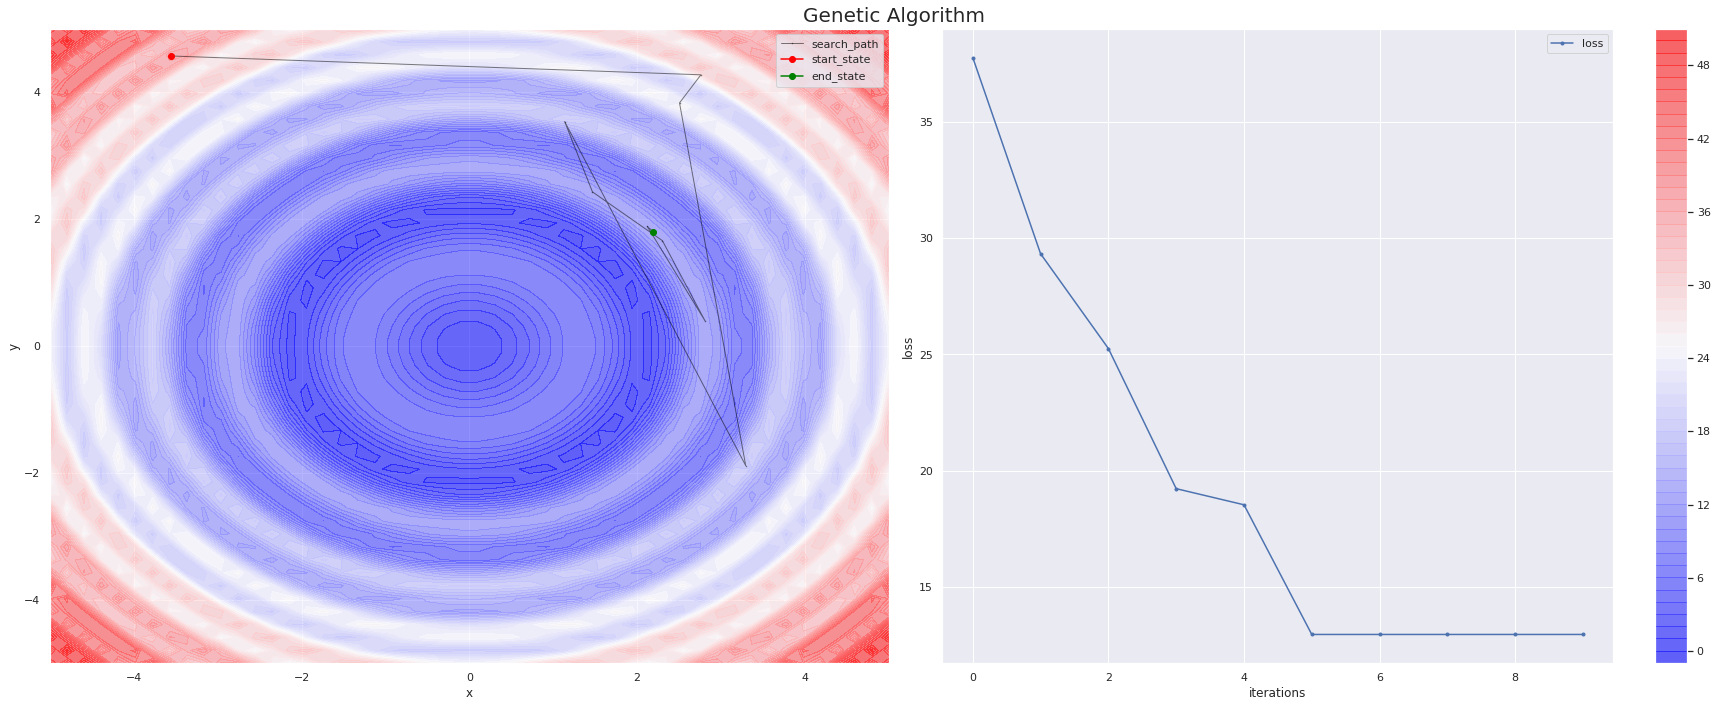

In [140]:
solver.plot_history()

2020-12-03 08:51:15,792, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc0374a5860>
2020-12-03 08:51:15,793, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-03 08:51:15,807, matplotlib.colorbar DEBUG Setting pcolormesh


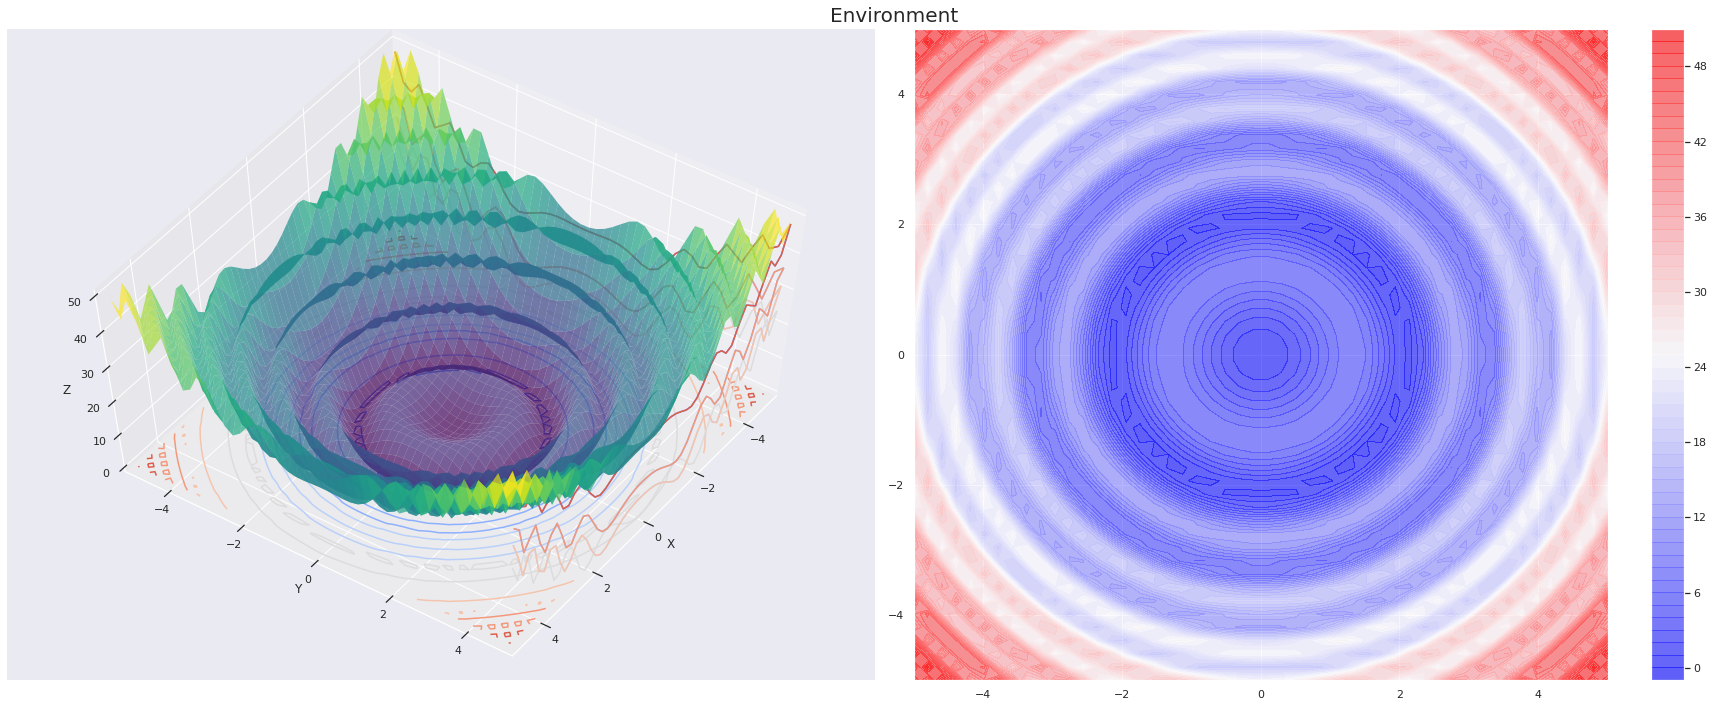

In [164]:
env.plot_environment()